# 🤖 LLM Trend Note
## [프로젝트] koGPT 업그레이드 하기 💪
1. 우리가 지난시간 살펴본 KoChatGPT 모델에 사용한 데이터셋은 아직 완벽히 정제되지 않았습니다.

2. Human Feedback이 반영된 데이터셋을 대체하기 위해 SFT와 RM 모델에 사용할 다양한 benchmark 데이터셋도 검토해볼 수 있습니다.

3. 언어모델의 생성능력을 좌우하는 최선의 디코딩을 위한 하이퍼파라미터 서치가 필요합니다.

4. 생성된 답변에 대한 주관적인 평가를 보완할 수 있는 정량적인 메트릭은 도입하지 않았었습니다.

5. LLM Trend Note1에서 살펴본 다양한 Instruction Tuning 및 Prompting 기법들도 적용해볼만 합니다.

6. 무엇보다 foundation model로 사용한 KoGPT-2는 Emergent abilities를 기대하기엔 다소 작은 사이즈의 모델입니다. 더 큰 파라미터 스케일을 가진 모델을 사용해보거나,

7. 더 효율적인 연산을 수행할 수 있는 LoRA의 적용 또는 새로운 Instruction Tuning 및 reward ranking 알고리즘을 도입해볼 수도 있습니다.

---

### 방법1) 기존 데이터셋 추가 정제
### 방법2) 새로운 데이터셋 추가
### 방법3) Foundation model 교체


In [1]:
import torch
import transformers

print("Torch version:{}".format(torch.__version__)) # Torch version:1.12.1
print("Cuda version: {}".format(torch.version.cuda)) # Cuda version: 11.3
print("transformers version: {}".format(transformers.__version__)) # transformers 4.28.0
print("GPU 사용 가능여부: {}".format(torch.cuda.is_available()))

Torch version:1.12.1
Cuda version: 11.3
transformers version: 4.28.0
GPU 사용 가능여부: True


## Base model and Dataset for RLHF
- FLAN의 Instruction Tuning이나 PaLM의 Prompt Engineering 
이 효과를 보기 위해선 언어모델의 입력을 단순한 query 형태로 주기보단 `정교한 입력 시퀀스를 설계`

## 방법3) Foundation model 교체
- 기존: skt/kogpt2-base-v2
- 교체: skt/ko-gpt-trinity-1.2B-v0.5

In [2]:
# Huggingface transformer - 토크나이저, 모델 불러오기
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import numpy

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "skt/ko-gpt-trinity-1.2B-v0.5"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

In [3]:
# 토크나이저가 입력받아 처리할 수 있는 최대 토큰 수 확인
tokenizer.max_model_input_sizes

{'gpt2': 1024,
 'gpt2-medium': 1024,
 'gpt2-large': 1024,
 'gpt2-xl': 1024,
 'distilgpt2': 1024}

In [4]:
# 토크나이징 확인
input_txt = "바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까."

In [5]:
tokens = tokenizer(input_txt).tokens()
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].numpy()

In [6]:
pd.options.display.max_columns = 40
pd.options.display.max_rows = 60
df = pd.DataFrame([tokens, input_ids[0]], index=["kogpt-2_tokens", "Input_IDs"])
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
kogpt-2_tokens,▁바람,도,▁없는,▁공,중에,▁수직,의,▁파,문을,▁내,이며,▁고요,히,▁떨어지는,▁오,동,잎,은,▁누구,의,▁발자,취,▁입,니까.
Input_IDs,31140,20780,30359,30016,31373,41427,25792,30163,31047,30024,31111,51068,29936,36152,30027,20801,25846,25768,31199,25792,44202,27472,30148,37708


In [7]:
max_length=128
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, do_sample=False)
print(tokenizer.decode(output_greedy[0]))

바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까. 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 



In [8]:
# 디코딩 성능 확인
max_length=128
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, do_sample=False)
print(tokenizer.decode(output_greedy[0]))

바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까. 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 



In [9]:
# 빔 서치 디코딩 사용, n-gram 패널티 부과
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_beam = model.generate(input_ids, max_length=max_length, num_beams=10, no_repeat_ngram_size=2,
                             do_sample=False)
print(tokenizer.decode(output_beam[0]))

바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까.</d>


In [10]:
# 샘플링 기법 추가
output_beam = model.generate(input_ids, max_length=max_length, num_beams=10, no_repeat_ngram_size=2,
                             do_sample=True, temperature=2.0, top_k=50)
print(tokenizer.decode(output_beam[0]))

바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까. 
 나그네 길손 발길을 멈추게 합니다. 
 
 秋風에 흔들리던 나뭇잎도 가을 바람 앞에서는 한 점 흔들림 없는 靜處(정처)인 것을 
 가을바람은 잎을 흔든다 잎은 흔들리면서도 다시 흔들리지 않는다. 
 내 生涯(생이)에 흔들리는 한 그 무엇도 나를 흔들어 흔들릴 수 없다. 
 이 가을이 가고 찬 서리가 내릴 때 나는 비로소 한 그루 풀잎이 된다. 
 내가 흔들리고 있을 때 바람은


#### top_p 샘플링 기법 사용
top_p 샘플링은 확률 분포 상에서 가장 높은 확률을 가진 단어들부터 선택해 누적 확률이 p 이상이 될 때까지 후보 단어를 포함시키고, 그 후보들 중에서 샘플링을 수행하는 방식

In [11]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=10, no_repeat_ngram_size=2,
                             do_sample=True, top_p=0.90)
print(tokenizer.decode(output_beam[0]))

바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까.</d>


kogpt-2에 `RLHF`를 적용하기기 위해선,`새로운 데이터셋`으로 일련의 재학습

SFT를 시도할 initial 모델에 쓸 데이터셋

In [12]:
import json 
data_path_1_SFT = 'kochatgpt_1_SFT.jsonl' 
with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

12000


[{'prompt': '불고기용 고기 한우에요?',
  'completion': "'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.",
  'tokens': 193},
 {'prompt': '쓰던 앱이 유료로 전환됐어',
  'completion': "'어떤 앱인지 모르기 때문에 정확한 답변을 드리기 어렵습니다. 하지만, 일반적으로 유료 전환된 앱은 기존 무료 앱에서 추가적인 기능이나 서비스를 제공하는 경우가 많습니다. 이 경우, 유료 전환 이전 가격이 매우 저렴하거나 무료인 경우가 많으므로, 앱을 계속 사용하려면 추가적인 비용을 지불해야 할 수 있습니다. 하지만, 유료 전환 이후에는 기존 사용자 또는 새로운 사용자 모두가 추가 기능과 높은 품질의 서비스를 이용할 수 있게 됩니다. 따라서, 앱 개발자는 유료 모델로 전환함으로써 앱의 수익을 증가시키고 더 나은 서비스를 제공할 수 있습니다.",
  'tokens': 288},
 {'prompt': '여친이랑 다툼',
  'completion': "'저는 인공지능이기 때문에 여친과의 다툼에 대해서는 조언을 드릴 수는 없습니다. 하지만 다투게 되면 상대방의 말을 경청하는 태도와 서로의 감정을 존중하는 것이 중요합니다. 논리적이고 차분한 대화를 통해 문제를 해결해보세요. 그리고 서로를 이해하고 서로의 의견을 수용하는 것이 중요합니다.",
  'tokens': 153}]

In [13]:
# RM에 사용할 데이터셋
data_path_2_RM = 'kochatgpt_2_RM.jsonl'
with open(data_path_2_RM, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

10220


[{'prompt': '번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나?',
  'completion_0': 'Allow me to answer your question. I know that you are curious about me.',
  'completion_1': '번디는 다양한 인터뷰자들과 뉴스홍보 담당자들과의 면담 때 밝혔다.',
  'completion_2': '라이언에게 말했다.',
  'ranking': [2, 1, 0]},
 {'prompt': '개포주공아파트는 몇 단지로 이루어져 있나?',
  'completion_0': '개포주공아파트는 다섯 단지로 이루어져 있습니다.',
  'completion_1': '이날 목송에서 구글상위노',
  'completion_2': '개포주공아파트는 총 27개 단지로 이루어져 있습니다.',
  'ranking': [2, 0, 1]},
 {'prompt': '김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?',
  'completion_0': 'The diameter of the Metallic domain is bigger than the Hyperonic domain.',
  'completion_1': '이 질문은 조금 불분명합니다. 김영삼 대통령이 후보 시절에 어떤 발언을 했고, 누가 그 발언을 문제삼았는지에 따라 답이 다를 수 있습니다.\\n\\n만약 김영삼 대통령이 후보 시절에 지역표심을 겨냥한 발언을 했다는 가정하에, 그 발언을 문제삼은 후보가 누구였는지를 대답하자면, 그 답은 이화선 당시 민주당 대통령 후보가 될 것입니다. 1992년 총선 때, 김영삼 대선후보는 "집값이 오른 노량진역 부근의 부동산 가격은 세월호 폭침 후 \\\'강남 도시재생\\\' 일환으로 상승했다"는 발언을 했습니다. 하지만 이화선 후보는 이 발언을 "전국적으로 경제적 발전이 이루어지지 않은 지방민의 마음을 멀리해지려는 무례한 발언"이라고 비판하며 문

In [14]:
# PPO 학습 데이터셋
data_path_3_PPO = 'kochatgpt_3_PPO.jsonl'
with open(data_path_3_PPO, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

12000


[{'prompt': '번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나?'},
 {'prompt': '개포주공아파트는 몇 단지로 이루어져 있나?'},
 {'prompt': '김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?'}]

### Supervised Fine-Tuning
#### SFT (instruction dataset)

In [15]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import Adam
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import Trainer, TrainingArguments
from copy import deepcopy
import copy
import logging
import json
from dataclasses import dataclass

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


모델과 토크나이저 불러오기(skt/ko-gpt-trinity-1.2B-v0.5)

Base model and Dataset for RLHF 참고.


In [16]:
from typing import Optional, Dict, Sequence
from torch.utils.data import Dataset
import transformers
import json
import copy
import logging
import torch

class SFT_dataset(Dataset):

    def __init__(self, data_path_1_SFT: str, tokenizer: transformers.PreTrainedTokenizer, max_length: int = 512, verbose=False):
        super(SFT_dataset, self).__init__()
        logging.warning("Loading data...")

        pattern_instruction = 'prompt'  # instruction
        pattern_output = 'completion'  # response

        with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
            list_data_dict = json.load(json_file)

        PROMPT_DICT = {
            "prompt_input": (
                "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
            )
        }

        prompt_input = PROMPT_DICT["prompt_input"]

        sources = []
        for example in list_data_dict:
            tmp = prompt_input.format_map(example)
            sources.append(tmp)

        targets = []
        for example in list_data_dict:
            targets.append(f"{example[pattern_output]}{tokenizer.eos_token}")
        examples = [s + t for s, t in zip(sources, targets)]

        # max_length 인자를 _tokenize_fn에 전달
        sources_tokenized = self._tokenize_fn(sources, tokenizer, max_length=max_length)  # source
        examples_tokenized = self._tokenize_fn(examples, tokenizer, max_length=max_length)  # source + target

        input_ids = examples_tokenized["input_ids"]
        labels = copy.deepcopy(input_ids)
        for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
            label[:source_len] = -100

        data_dict = dict(input_ids=input_ids, labels=labels)

        self.input_ids = data_dict["input_ids"]
        self.labels = data_dict["labels"]
        logging.warning("Loading data done!!: %d"%(len(self.labels)))

    def _tokenize_fn(self, strings: Sequence[str], tokenizer: transformers.PreTrainedTokenizer, max_length: int) -> Dict:
        tokenized_list = [
            tokenizer(
                text,
                return_tensors="pt",
                padding="longest",
                max_length=max_length,  # max_length 인자를 사용하여 길이 제한 설정
                truncation=True,       # truncation=True로 길이 제한 설정
            )
            for text in strings
        ]
        input_ids = [tokenized["input_ids"][0] for tokenized in tokenized_list]
        input_ids_lens = [tokenized["input_ids"].ne(tokenizer.pad_token_id).sum().item() for tokenized in tokenized_list]

        return dict(
            input_ids=input_ids,
            input_ids_lens=input_ids_lens,
        )

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])


In [17]:
@dataclass
class DataCollatorForSupervisedDataset(object): 

    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value= -100)
        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

In [18]:
# SFT_dataset 클래스를 사용해 훈련셋 만들기
# data collator 인스턴스 만들기
tokenizer.pad_token = tokenizer.eos_token

train_dataset = SFT_dataset(
    data_path_1_SFT='kochatgpt_1_SFT.jsonl', 
    tokenizer=tokenizer,
    max_length=512,     # 최대 길이 설정 (필요에 따라 조정 가능)

)
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

print('input : %s'%train_dataset.input_ids[0])
print('output: %s'%train_dataset.labels[0])

input : tensor([30132, 42872, 33313, 30679, 40479, 39911,   384, 22509, 21921, 25372,
          385, 31245, 23280, 34957, 25617, 36539, 29991, 25624, 25400, 31167,
          376, 42872,   379, 46803,   456, 30303, 35353,   384, 25785, 20573,
        37780,   383, 46900, 43226,   565, 27071, 23151, 31555, 41690, 35071,
        25400, 31269, 32677, 30765, 31810, 36229, 30326, 33889, 30093, 34957,
        25617, 30021, 30434, 29991, 39687, 34036, 19016, 31997, 49906, 19352,
        30011, 30904, 36731, 43502, 30228, 31214, 30326, 29991, 31621, 33314,
        34347, 30843, 50342, 33512, 31370, 34243, 29991, 35144, 32586, 32622,
        44680, 30110, 21844, 39826, 34803, 31356, 39075, 30242, 36966, 29985,
        34179, 36513, 30718, 35557, 32361, 31018, 29404, 35942, 19352, 41049,
            1])
output: tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -1

In [19]:
# train_dataset.input_ids[0]를 디코딩

decoded_input = tokenizer.decode(train_dataset.input_ids[0], skip_special_tokens=True)
print(decoded_input)

### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.


In [20]:
#  Training arguments를 사용해 trainer 클래스를 정의

training_args = TrainingArguments(
    output_dir="/aiffel/KoChatGPT/test",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    learning_rate=5e-5,
    prediction_loss_only=True,
    fp16 = True,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,  # 그래디언트 체크포인팅
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset
)

In [21]:
pip install psutil

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.


In [22]:
import psutil

# 메모리 정보를 GiB 단위로 가져오기
total_memory = psutil.virtual_memory().total / (1024 ** 3)
available_memory = psutil.virtual_memory().available / (1024 ** 3)

print(f"Total Memory: {total_memory:.2f} GiB")
print(f"Available Memory: {available_memory:.2f} GiB")

Total Memory: 17.57 GiB
Available Memory: 13.87 GiB


In [23]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

SFT 훈련

In [24]:
# 설정 추가
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# 메모리 정리
import torch
torch.cuda.empty_cache()

# 학습 및 저장
trainer.train()
model.save_pretrained('/aiffel/KoChatGPT/output_1_SFT')

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:10                                                                                   │
│                                                                                                  │
│    7 torch.cuda.empty_cache()                                                                    │
│    8                                                                                             │
│    9 # 학습 및 저장                                                                              │
│ ❱ 10 trainer.train()                                                                             │
│   11 model.save_pretrained('/aiffel/KoChatGPT/output_1_SFT')                                     │
│   12                                                                                             │
│                                                                                                  │
│ /opt/conda/lib/python3.9/site-packages/transformers/trainer.py:1662 in train                     │
│                                                                                                  │
│   1659 │   │   inner_training_loop = find_executable_batch_size(                                 │
│   1660 │   │   │   self._inner_training_loop, self._train_batch_size, args.auto_find_batch_size  │
│   1661 │   │   )                                                                                 │
│ ❱ 1662 │   │   return inner_training_loop(                                                       │
│   1663 │   │   │   args=args,                                                                    │
│   1664 │   │   │   resume_from_checkpoint=resume_from_checkpoint,                                │
│   1665 │   │   │   trial=trial,                                                                  │
│                                                                                                  │
│ /opt/conda/lib/python3.9/site-packages/transformers/trainer.py:1991 in _inner_training_loop      │
│                                                                                                  │
│   1988 │   │   │   │   │   │   │   xm.optimizer_step(self.optimizer)                             │
│   1989 │   │   │   │   │   elif self.do_grad_scaling:                                            │
│   1990 │   │   │   │   │   │   scale_before = self.scaler.get_scale()                            │
│ ❱ 1991 │   │   │   │   │   │   self.scaler.step(self.optimizer)                                  │
│   1992 │   │   │   │   │   │   self.scaler.update()                                              │
│   1993 │   │   │   │   │   │   scale_after = self.scaler.get_scale()                             │
│   1994 │   │   │   │   │   │   optimizer_was_run = scale_before <= scale_after                   │
│                                                                                                  │
│ /opt/conda/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:338 in step                 │
│                                                                                                  │
│   335 │   │                                                                                      │
│   336 │   │   assert len(optimizer_state["found_inf_per_device"]) > 0, "No inf checks were rec   │
│   337 │   │                                                                                      │
│ ❱ 338 │   │   retval = self._maybe_opt_step(optimizer, optimizer_state, *args, **kwargs)         │
│   339 │   │                                                                                      │
│   340 │   │   optimizer_state["stage"] = OptState.STEPPED                                        │
│   341                                                                                            │
│                                                                 

In [ ]:
generator = pipeline('text-generation', model='/aiffel/KoChatGPT/output_1_SFT', tokenizer=tokenizer)

generation_args = dict(   
    num_beams=4,
    repetition_penalty=2.0,
    no_repeat_ngram_size=4,
    eos_token_id=375, # \n   
    max_new_tokens=64,
    do_sample=True,
    top_k=50,
    early_stopping=True
)

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = ['불고기용 고기 한우에요?',
               '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
               '시카고 오헤어 국제공항은 어디에 있어?',
               '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt' : tmp}) for tmp in list_prompt]

list_result = generator(list_prompt, **generation_args)   
for prompt, result in zip(list_prompt, list_result):
    print()
    print((result[0]['generated_text']))

In [ ]:
torch.cuda.empty_cache()

## 방법1) 기존 데이터셋 추가 정제
말뭉치를 정제하여 SFT 데이터셋을 개선하고 모델의 성능을 평가하는 방법입니다.

In [ ]:
import json
from datasets import load_metric
from transformers import Trainer, TrainingArguments, AutoTokenizer, AutoModelForSequenceClassification

# 데이터 로드 및 EDA 수행
with open('data_kochatgpt/kochatgpt_1_SFT.jsonl', 'r', encoding='utf-8') as f:
    data = [json.loads(line) for line in f]

# EDA 결과에 따라 데이터 정제 (예: 긴 문장 제외, 중복 제거)
filtered_data = [entry for entry in data if len(entry['completion']) < 150]  # 예시로 150 토큰 이하로 필터링

# 토크나이저 설정
tokenizer = AutoTokenizer.from_pretrained("skt/kogpt2-base-v2")

# 데이터셋 Tokenization
def preprocess_function(examples):
    return tokenizer(examples['prompt'], examples['completion'], truncation=True, padding="max_length")

# 데이터셋 변환 및 데이터 증강
dataset = Dataset.from_dict(filtered_data)
tokenized_dataset = dataset.map(preprocess_function, batched=True)

# BLEU, ROUGE 등 평가 지표 설정
metric_bleu = load_metric("bleu")
metric_rouge = load_metric("rouge")

# 모델 학습
model = AutoModelForSequenceClassification.from_pretrained("skt/kogpt2-base-v2")
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    compute_metrics=compute_metrics,  # BLEU, ROUGE 계산 함수 정의 필요
)

trainer.train()


### Reward Model

In [ ]:
pip install chatgpt

In [ ]:
import os
import json
from typing import Optional
import torch
import torch.nn as nn
from torch.optim import Adam
from chatgpt import dataset
from chatgpt.dataset import RewardDataset
from chatgpt.models.base import RewardModel
from chatgpt.trainer import RewardModelTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoConfig
from transformers.models.gpt2.configuration_gpt2 import GPT2Config
from transformers.models.gpt2.modeling_gpt2 import GPT2Model
import loralib as lora

### GPTRM_custom 이라는 이름으로 클래스를 선언

In [ ]:
class GPTRM_custom(RewardModel):

    def __init__(self,
                 pretrained: Optional[str] = None,
                 config: Optional[GPT2Config] = None,
                 checkpoint: bool = False,
                 lora_rank: int = 0,
                 lora_train_bias: str = 'none',
                 tokenizer=None) -> None:
        if pretrained is not None:
            model = GPT2Model.from_pretrained(pretrained)
            model.resize_token_embeddings(len(tokenizer))
        elif config is not None:
            model = GPT2Model(config)
        else:
            model = GPT2Model(GPT2Config())
        if checkpoint:
            model.gradient_checkpointing_enable()

        value_head = nn.Linear(model.config.n_embd, 1)
        super().__init__(model, value_head, lora_rank, lora_train_bias)

        if pretrained is not None:
            self.model = model
            self.pretrained = pretrained


    def save_pretrained(self, dir):
        if self.pretrained is not None:
            self.model.save_pretrained(dir)

In [ ]:
#model = AutoModelForCausalLM.from_pretrained('skt/ko-gpt-trinity-1.2B-v0.5')
#tokenizer = AutoTokenizer.from_pretrained('skt/ko-gpt-trinity-1.2B-v0.5')


# with구문의 NaiveStrategy()는 Strategy클래스를 상속한 NaiveStrategy클래스
with NaiveStrategy().model_init_context():
        model = GPTRM_custom(pretrained='skt/ko-gpt-trinity-1.2B-v0.5', lora_rank=0, tokenizer=tokenizer).cuda()

In [ ]:
# ranking dataset(RM 훈련)
with open('/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_2_RM.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

total_data_ranking2chosen = []
for tmp in list_data_dict:
    one_data_ranking2chosen = []

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][1]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_1']
    else:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][1] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_1']
    one_data_ranking2chosen.append(data)


    total_data_ranking2chosen.extend(one_data_ranking2chosen)

print('before data num: %d'%(len(list_data_dict)))
print('after  data num: %d'%(len(total_data_ranking2chosen)))
print('data example: \n%s'%total_data_ranking2chosen[45])

In [ ]:
#  완성한 ranking dataset을 shuffle한 후 훈련셋 생성

import random
random.seed(230319)
random.shuffle(total_data_ranking2chosen)
print(total_data_ranking2chosen[45])

In [ ]:
train_data = total_data_ranking2chosen[:1000] 
eval_data = total_data_ranking2chosen[1000:1200]

print(len(train_data))
print(len(eval_data))

train_dataset = RewardDataset(train_data, tokenizer, 256)
eval_dataset = RewardDataset(eval_data, tokenizer, 256)

In [ ]:
# 데이터셋 확인
idx = 1
print('#'*70)
print('## prompt ##')
print(train_data[idx]['prompt'])
print('#'*70)
print('## chosen ##')
print(train_data[idx]['chosen'])
print('#'*70)
print('## rejected ##')
print(train_data[idx]['rejected'])

## 방법2) 새로운 데이터셋 추가
웹크롤링이나 공개된 데이터셋을 활용하여 새로운 데이터셋을 추가하고 모델 성능을 비교합니다.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset, DatasetDict

# 새로운 데이터셋 로드 및 전처리
new_data = load_dataset('korquad', 'v2.0')  # KorQuAD 예시
train_data = new_data['train'].map(preprocess_function, batched=True)
eval_data = new_data['validation'].map(preprocess_function, batched=True)

# 데이터셋 병합
merged_train_dataset = DatasetDict({'train': tokenized_dataset['train'] + train_data})
merged_eval_dataset = DatasetDict({'validation': tokenized_dataset['validation'] + eval_data})

# 모델 재학습
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=merged_train_dataset['train'],
    eval_dataset=merged_eval_dataset['validation'],
    compute_metrics=compute_metrics,
)
trainer.train()

# 성능 평가
results = trainer.evaluate()
print("Merged Dataset Evaluation:", results)


#### RM 학습, 1Epoch

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64"


In [ ]:
trainer = RewardModelTrainer(model=model,
                             strategy=NaiveStrategy(),
                             optim=Adam(model.parameters(), lr=5e-5),
                             train_dataset=train_dataset,
                             eval_dataset=eval_dataset,
                             batch_size=2,  # batch size를 줄임
                             max_epochs=1)


In [ ]:
trainer.fit(use_lora=1)

model.save_pretrained('aiffel/KoChatGPT/output_2_RM')

### 오류!!
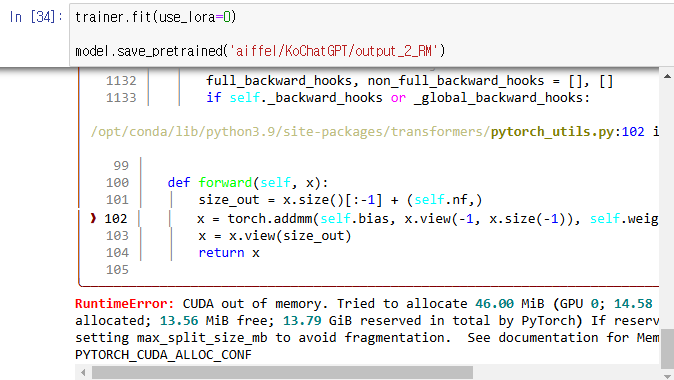

학습 후 사전훈련 모델을 저장하려다 메모리 부족 현상으로 인해 오류.
```
import gc
import torch

gc.collect()
torch.cuda.empty_cache()
```
```
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64"
```

방식 등 으로 GPU 메모리가 부족해서 발생한 문제를 해결

#### RM 학습 확인 및 적절한 reward score 출력 확인

In [ ]:
def inference_RM(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    output = model(input_ids)
    output_reward = output.cpu().detach().numpy()[0]

    print('input: %s\nreward score: %.1f'%(input_text, output_reward))

    return output_reward

input_text = '인공지능은 똥멍청이 입니다'
output_reward = inference_RM(input_text=input_text)

In [ ]:
input_text = '인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다.'

output_reward = inference_RM(input_text=input_text)

In [ ]:
input_text = "인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다. AI는 현대적인 컴퓨팅 혁신에서 중추적인 역할을 하며 개인과 비즈니스의 가치를 창출합니다. 예를 들어 광학 문자 인식(OCR)은 AI를 사용해 이미지 및 문서에서 텍스트 및 데이터를 추출하고, 구조화되지 않은 콘텐츠를 비즈니스에 바로 사용할 수 있게 만들고, 유용한 정보를 창출합니다."

output_reward = inference_RM(input_text=input_text)

In [ ]:
input_text = "인공지능은 일반적으로 인간의 지능이 필요하거나 인간이 분석할 수 있는 것보다 규모가 큰 데이터를 포함하는 방식으로 추론, 학습 및 행동할 수 있는 컴퓨터 및 기계를 구축하는 것과 관련된 과학 분야입니다. AI는 컴퓨터 공학, 데이터 분석 및 통계, 하드웨어 및 소프트웨어 엔지니어링, 언어학, 신경 과학은 물론 철학과 심리학을 포함하여 여러 학문을 포괄하는 광범위한 분야입니다. 비즈니스의 운영 수준에서 AI는 주로 머신러닝과 딥 러닝을 기반으로 하는 기술 모음으로, 데이터 분석, 예상 및 예측, 객체 분류, 자연어 처리, 추천, 지능형 데이터 가져오기 등을 수행할 수 있습니다."

output_reward = inference_RM(input_text=input_text)

In [ ]:
# 메모리 관리(캐시 비우기)
torch.cuda.empty_cache()

### PPO

In [ ]:
from copy import deepcopy

import torch
from torch.optim import Adam
from chatgpt.models.base import RewardModel
from chatgpt.models.gpt import GPTActor, GPTCritic
from chatgpt.trainer import PPOTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from transformers import AutoTokenizer

In [ ]:
with NaiveStrategy().model_init_context():
    actor = GPTActor(pretrained='/aiffel/KoChatGPT/output_1_SFT', lora_rank=0).to(torch.cuda.current_device())
    critic = GPTCritic(pretrained='aiffel/KoChatGPT/output_2_RM', lora_rank=0).to(torch.cuda.current_device())

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    initial_model = deepcopy(actor)
    reward_model = RewardModel(deepcopy(critic.model), deepcopy(critic.value_head)).to(torch.cuda.current_device())

In [ ]:
# 모델 학습에 사용할 옵티마이저, 모델 준비
actor_optim = Adam(actor.parameters(), lr=5e-6)
critic_optim = Adam(critic.parameters(), lr=5e-6)

In [ ]:
(actor, actor_optim), (critic, critic_optim), reward_model, initial_model = NaiveStrategy().prepare(
    (actor, actor_optim), (critic, critic_optim), reward_model, initial_model)

In [ ]:
# PPO 학습에 쓸 데이터 불러와 토크나이징
with open('/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_3_PPO.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)
    list_prompt = [tmp['prompt'] for tmp in list_data_dict]

def tokenize_fn(texts):
    batch = tokenizer(texts, return_tensors='pt', max_length=96, padding=True, truncation=True)
    return {k: v.cuda() for k, v in batch.items()}

In [ ]:
print(tokenize_fn('It takes something more than intelligence to act intelligently.'))

In [ ]:
len(list_prompt)

### PPOTrainer 클래스 설계 및 학습

In [ ]:
trainer = PPOTrainer(NaiveStrategy(),
                     actor,
                     critic,
                     reward_model,
                     initial_model,
                     actor_optim,
                     critic_optim,
                     max_epochs=1,  
                     train_batch_size=8, 
                     tokenizer=tokenize_fn,
                     max_length=128,
                     do_sample=True,
                     temperature=1.0,
                     top_k=50,
                     pad_token_id=tokenizer.pad_token_id,
                     eos_token_id=tokenizer.eos_token_id)

In [ ]:
# PPO 학습
trainer.fit(list_prompt, 
            num_episodes=10,  
            max_timesteps=3,
            update_timesteps=3)

model.save_pretrained('aiffel/KoChatGPT/output_3_PPO')

In [ ]:
# RLHF 적용된 koGPT-2 생성능력 확인
def generation(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    outputs = actor.generate(input_ids,
                             max_length=250,
                             do_sample=True,
                             top_k=50,
                             top_p=0.95,
                             num_return_sequences=1)
    output = tokenizer.batch_decode(outputs[0], skip_special_tokens=True)[0]
    print()
    print(output)
    return output

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = [
    '불고기용 고기 한우에요?', 
    '리처드 닉슨이 43대 부통령직을 수행한 년도는?', 
    '시카고 오헤어 국제공항은 어디에 있어',
    '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt': tmp}) for tmp in list_prompt]

for input_text in list_prompt:
    output = generation(input_text)

## 회고
해결못해서 너무 아쉬웠다ㅜ CUDA memory 문제가 너무너무 날 힘드게 만들어서
모든 시간을 다 쏟아부었는데도 해결하지 못한게 아쉽다.

그리고 노드를 재시작하고 다시 restart해도 처음에는 진행이 잘 되었던 곳에서

다시 실행해봤을 때, memory 문제로 실행이 안되는게 너무 억울했다 ㅜ

그냥 모델 바꾸지말고 다른 방법으로 진행해볼 걸 생각도 들어서 오늘 학습 끝나고 다시 한번 진행해 볼 예정이다.